<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
    Understanding Model History Object: Classification Task
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
#
# ==========================================================
# Lesson: Early Stopping Callbacks in Deep Learning
#         California Housing Price Prediction Case Study
# ==========================================================
# ## Learning Objectives
# This example will enable you to:
# 1. Implement early stopping in regression problems
# 2. Configure early stopping parameters effectively
# 3. Monitor and analyze training metrics
# 4. Visualize the impact of early stopping
# 5. Evaluate model performance with early stopping
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [1]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

import os  
import shutil
from datetime import datetime

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import tensorflow
import tensorflow as tf

# Set styling for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2024-12-30

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
numpy     : 1.26.4
tensorflow: 2.16.2
sklearn   : 1.5.1



In [2]:
def cleanup_directory(directory_path):
    """
    Deletes the specified directory and all its contents.

    Args:
        directory_path (str): Path to the directory to delete.
    """
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directory '{os.path.basename(directory_path)}' deleted successfully.")
    else:
        print(f"Directory '{os.path.basename(directory_path)}' does not exist or is not a directory.")

### ML Model Raodmap
1. Read the data
2. Explore the data

3. Processing
    - Numerical features (scaling)
    
4. Splitting the data

In [6]:
# ==================================================== #
#        Implementing ModelCheckpoint 
#        Callback with Synthetic data
# ==================================================== #

In [6]:
# Load an process data
def load_and_preprocess_data(random_state = 101):
    """Load and preprocess the California Housing dataset"""
    # Load data
    housing = fetch_california_housing()
    X, y = housing.data, housing.target
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, housing.feature_names


def create_model(input_shape):
    """Create a more complex model for this challenging regression task"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(1)  # Output layer for regression
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',    # Mean Squared Error for regression
        metrics=['mae']  # Mean Absolute Error for interpretability
    )
    
    return model

In [11]:
def train_with_early_stopping():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data()
    
    # Create model
    model = create_model((X_train.shape[1],))
    
    # Create checkpoint directory
    checkpoint_dir = 'housing_model_checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,                     # Be patient as this is a complex dataset
        min_delta=0.0001,                # Minimum change to qualify as an improvement
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=200,                 # Set high, early stopping will prevent overfitting
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    return model, history, X_test, y_test


def plot_training_history(history):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model Mean Absolute Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_results(model, X_test, y_test, history):
    """Evaluate and print model results"""
    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Get training statistics
    best_epoch = np.argmin(history.history['val_loss']) + 1
    total_epochs = len(history.history['loss'])
    best_val_loss = min(history.history['val_loss'])
    best_val_mae = min(history.history['val_mae'])
    
    print("\nModel Performance Summary:")
    print("-" * 50)
    print(f"Best validation loss achieved at epoch: {best_epoch}/{total_epochs}")
    print(f"Best validation loss (MSE): {best_val_loss:.4f}")
    print(f"Best validation MAE: {best_val_mae:.4f}")
    print(f"Test loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print("-" * 50)
    print("\nEarly stopping saved us from training for the full 200 epochs!")

Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.6411 - mae: 1.8228
Epoch 1: val_loss improved from inf to 1.34016, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 4.6346 - mae: 1.8213 - val_loss: 1.3402 - val_mae: 0.8513
Epoch 2/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9829 - mae: 0.7409
Epoch 2: val_loss improved from 1.34016 to 0.49798, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.9810 - mae: 0.7400 - val_loss: 0.4980 - val_mae: 0.5001
Epoch 3/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5644 - mae: 0.5549
Epoch 3: val_loss improved from 0.49798 to 0.41853, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.5643 - mae: 0.5549 - val_loss: 0.4185 - val_mae: 0.4671
Epoch 4/200
206/207 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4946 - mae: 0.5172
Epoch 4: val_lo

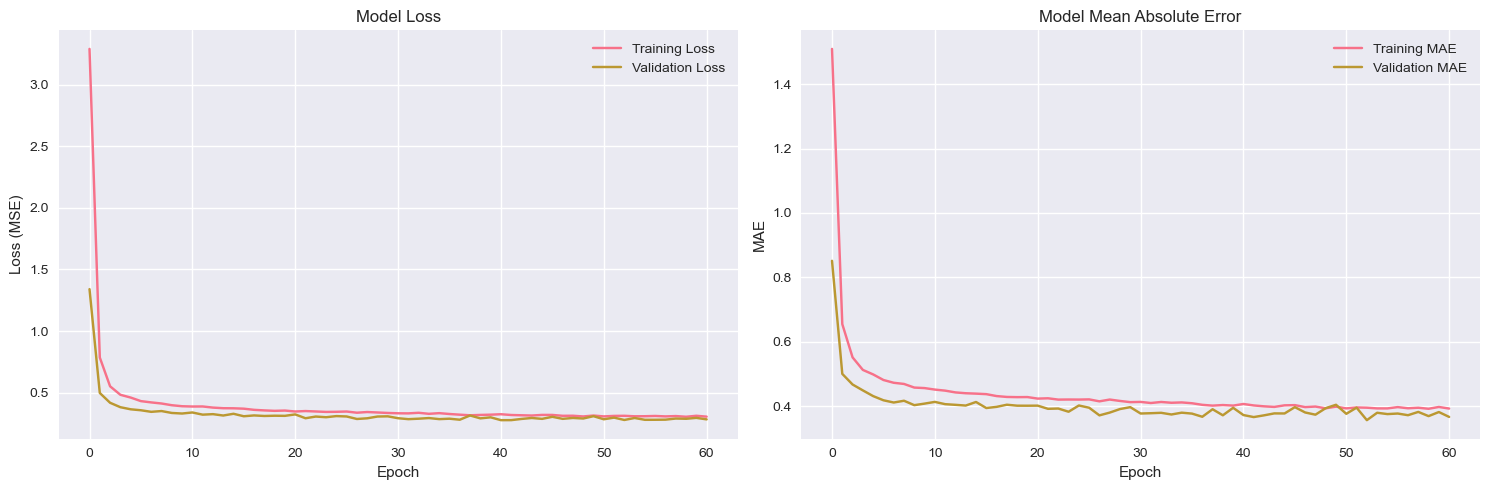


Model Performance Summary:
--------------------------------------------------
Best validation loss achieved at epoch: 41/61
Best validation loss (MSE): 0.2774
Best validation MAE: 0.3563
Test loss (MSE): 0.3127
Test MAE: 0.3881
--------------------------------------------------

Early stopping saved us from training for the full 200 epochs!


In [12]:
if __name__ == "__main__":
    # Train model
    model, history, X_test, y_test = train_with_early_stopping()
    
    # Plot results
    plot_training_history(history)
    
    # Evaluate and print results
    evaluate_results(model, X_test, y_test, history)